
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
N_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

from copy import deepcopy

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian.mggpo import MGGPOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs


evaluator = Evaluator(function=evaluate_TNK)
evaluator.max_workers = 10

# test check options
vocs = deepcopy(tnk_vocs)
gen = MGGPOGenerator(vocs=vocs, reference_point = {"y1":1.5,"y2":1.5})
gen.n_monte_carlo_samples = N_MC_SAMPLES
gen.numerical_optimizer.n_restarts = NUM_RESTARTS
X = Xopt(evaluator=evaluator, generator=gen, vocs=vocs)
X.evaluate_data(pd.DataFrame({"x1": [1.0, 0.75], "x2": [0.75, 1.0]}))

X


            Xopt
________________________________
Version: 0+untagged.1.g27fc0ce
Data size: 2
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0
    sleep: 0
  max_workers: 10
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  ga_generator:
    crossover_probability: 0.9
    mutation_probability: 1.0
    output_path: null
    population: null
    population_file: null
    population_size: 64
    supports_multi_objective: true
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: mggpo
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
  

In [2]:
for i in range(10):
    print(i)
    X.step()

0


1


2


3


4


5


6


7


8


9


In [3]:
X.generator.data

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,1.000000,0.750000,dummy_constant,1.000000,0.750000,0.626888,0.312500,0.000034,False
1,0.750000,1.000000,dummy_constant,0.750000,1.000000,0.626888,0.312500,0.000008,False
2,2.806161,0.524204,dummy_constant,2.806161,0.524204,7.247588,5.318963,0.000022,False
3,2.469286,0.074500,dummy_constant,2.469286,0.074500,5.014341,4.059136,0.000008,False
4,2.751570,0.732357,dummy_constant,2.751570,0.732357,7.159780,5.123557,0.000007,False
...,...,...,...,...,...,...,...,...,...
97,0.482215,0.839251,dummy_constant,0.482215,0.839251,-0.016039,0.115407,0.000006,False
98,0.267304,0.903662,dummy_constant,0.267304,0.903662,-0.100888,0.217090,0.000005,False
99,0.267527,0.903662,dummy_constant,0.267527,0.903662,-0.101129,0.216987,0.000005,False
100,0.265435,0.888859,dummy_constant,0.265435,0.888859,-0.132551,0.206232,0.000005,False


## plot results


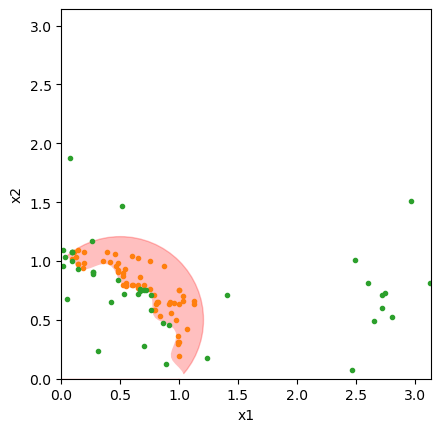

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

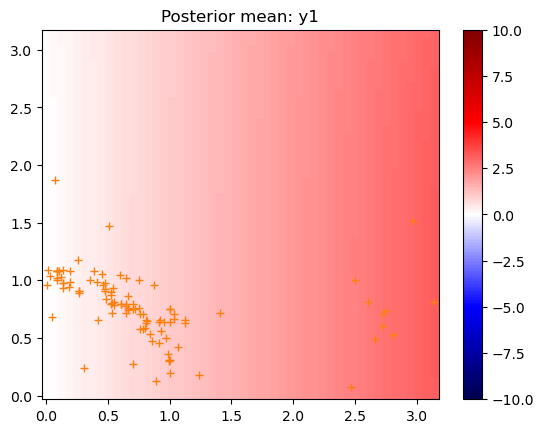

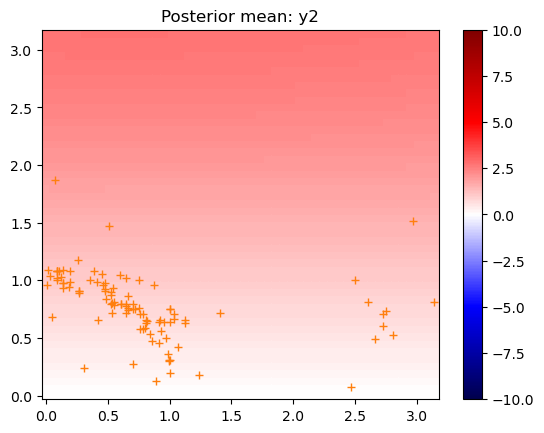

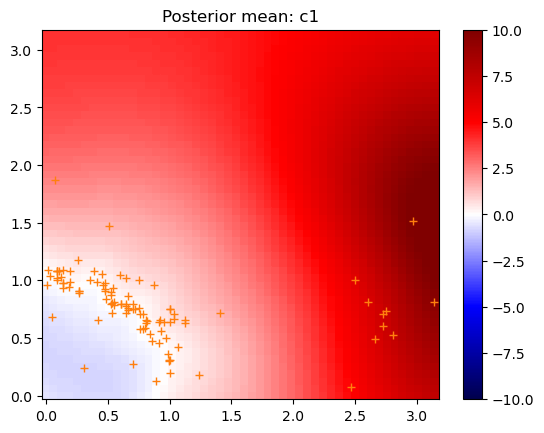

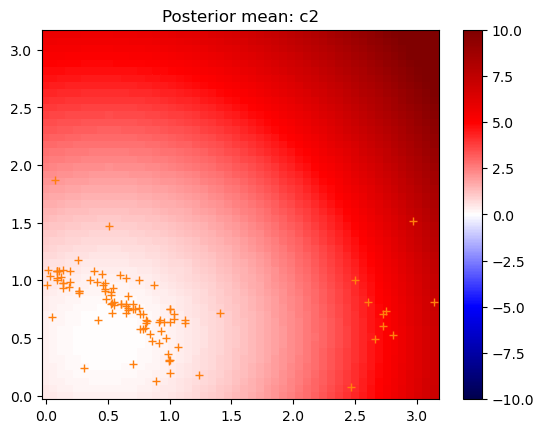

In [5]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.train_model(X.generator.data)

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

xx, yy = xx.numpy(), yy.numpy()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n),
            cmap="seismic",
            vmin=-10.0,
            vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

[[0.18942321 0.96140022]]


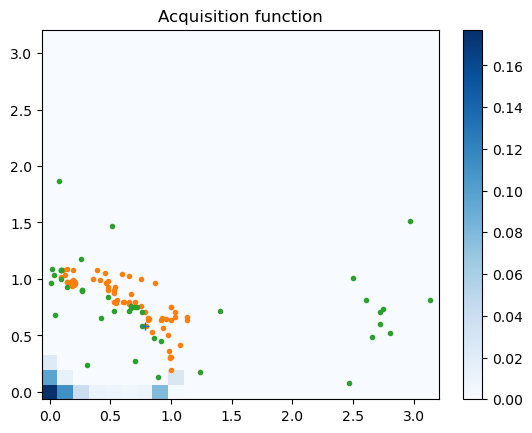

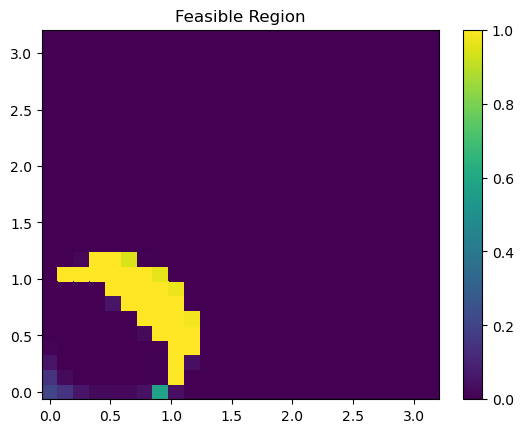

In [6]:
# plot the acquisition function
from xopt.generators.bayesian.objectives import feasibility

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 25
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

xx, yy = xx.numpy(), yy.numpy()

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
    ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

    ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")

    feas = feasibility(pts.unsqueeze(1), model, tnk_vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

candidate = pd.DataFrame(X.generator.generate(1), index=[0])
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")